<a href="https://colab.research.google.com/github/manuaishika/softkmeans-nn/blob/main/imsoft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Device: cpu
Running quick demo...
Training for 30 epochs...
Epoch [ 10/30]: Total Loss: 0.5917, K-Means: 0.0457
Epoch [ 20/30]: Total Loss: 23.9023, K-Means: 0.0000
Epoch [ 30/30]: Total Loss: 151.0183, K-Means: 0.0000


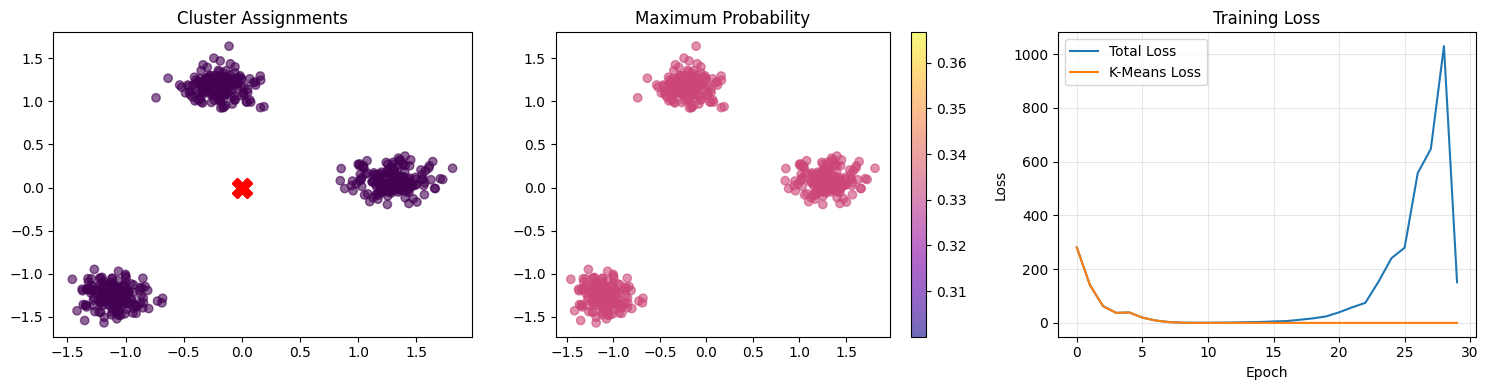

Cluster distribution: [  0   0 500]
Demo completed!


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

class SoftKMeansLayer(nn.Module):
    def __init__(self, input_dim, num_clusters, temperature=1.0):
        super().__init__()
        self.num_clusters = num_clusters
        self.temperature = temperature
        self.temperature_factor = nn.Parameter(torch.tensor([temperature]))
        self.centroids = nn.Parameter(torch.randn(num_clusters, input_dim) * 0.1)

    def forward(self, x):
        x_norm = (x ** 2).sum(dim=1, keepdim=True)
        c_norm = (self.centroids ** 2).sum(dim=1, keepdim=True).t()
        distances = x_norm + c_norm - 2 * torch.mm(x, self.centroids.t())
        logits = -distances / self.temperature_factor
        responsibilities = F.softmax(logits, dim=1)
        return responsibilities, distances

    def get_centroids(self):
        return self.centroids.data

class SoftKMeansNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_clusters, temperature=1.0):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
            prev_dim = hidden_dim
        self.encoder = nn.Sequential(*layers)
        self.soft_kmeans = SoftKMeansLayer(prev_dim, num_clusters, temperature)

    def forward(self, x):
        features = self.encoder(x)
        responsibilities, distances = self.soft_kmeans(features)
        return features, responsibilities, distances

    def predict(self, x):
        with torch.no_grad():
            _, responsibilities, _ = self.forward(x)
            return torch.argmax(responsibilities, dim=1)

    def get_centroids(self):
        return self.soft_kmeans.get_centroids()

    def get_soft_assignments(self, x):
        with torch.no_grad():
            _, responsibilities, _ = self.forward(x)
            return responsibilities

class SoftKMeansTrainer:
    def __init__(self, model, learning_rate=0.001, lambda_reg=0.01):
        self.model = model
        self.model.to(device)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        self.lambda_reg = lambda_reg
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', patience=10, factor=0.5
        )

    def kmeans_loss(self, responsibilities, distances):
        return torch.sum(responsibilities * distances)

    def entropy_regularization(self, responsibilities):
        entropy = -torch.sum(responsibilities * torch.log(responsibilities + 1e-10), dim=1)
        return torch.mean(entropy)

    def centroid_regularization(self):
        centroids = self.model.get_centroids()
        centroid_distances = torch.cdist(centroids, centroids, p=2)
        mask = ~torch.eye(centroid_distances.size(0), dtype=torch.bool).to(device)
        min_distance = torch.min(centroid_distances[mask])
        return 1.0 / (min_distance + 1e-10)

    def train_step(self, x_batch):
        self.optimizer.zero_grad()
        _, responsibilities, distances = self.model(x_batch)
        main_loss = self.kmeans_loss(responsibilities, distances)
        entropy_loss = self.entropy_regularization(responsibilities)
        reg_loss = self.centroid_regularization()
        total_loss = main_loss + 0.1 * entropy_loss + self.lambda_reg * reg_loss
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        self.optimizer.step()
        return {
            'total_loss': total_loss.item(),
            'kmeans_loss': main_loss.item(),
            'entropy_loss': entropy_loss.item(),
            'reg_loss': reg_loss.item()
        }

    def train(self, data_loader, num_epochs=100, verbose=True):
        history = {
            'total_loss': [], 'kmeans_loss': [],
            'entropy_loss': [], 'reg_loss': []
        }
        for epoch in range(num_epochs):
            epoch_losses = {'total_loss': 0, 'kmeans_loss': 0,
                          'entropy_loss': 0, 'reg_loss': 0}
            for x_batch, _ in data_loader:
                x_batch = x_batch.to(device)
                losses = self.train_step(x_batch)
                for key in losses:
                    epoch_losses[key] += losses[key]
            for key in epoch_losses:
                epoch_losses[key] /= len(data_loader)
                history[key].append(epoch_losses[key])
            self.scheduler.step(epoch_losses['total_loss'])
            if verbose and (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1:3d}/{num_epochs}]: "
                      f"Total Loss: {epoch_losses['total_loss']:.4f}, "
                      f"K-Means: {epoch_losses['kmeans_loss']:.4f}")
        return history

def create_dataset(dataset_type='blobs', n_samples=1000, n_clusters=4):
    if dataset_type == 'blobs':
        X, y = make_blobs(n_samples=n_samples, centers=n_clusters, cluster_std=0.8, random_state=42)
    elif dataset_type == 'moons':
        X, y = make_moons(n_samples=n_samples, noise=0.1, random_state=42)
        n_clusters = 2
    elif dataset_type == 'circles':
        X, y = make_circles(n_samples=n_samples, factor=0.5, noise=0.05, random_state=42)
        n_clusters = 2
    else:
        raise ValueError(f"Unknown dataset type: {dataset_type}")

    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X_tensor = torch.FloatTensor(X).to(device)
    y_tensor = torch.LongTensor(y).to(device)
    dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
    return X_tensor, y_tensor, data_loader, n_clusters

def visualize_results(X, predictions, soft_probs, centroids, history=None, title="Results"):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    axes[0,0].scatter(X[:, 0], X[:, 1], c=predictions, cmap='tab20', alpha=0.6, s=30)
    axes[0,0].scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=300, linewidths=2, edgecolor='black')
    axes[0,0].set_title('Cluster Assignments')

    uncertainty = 1 - np.max(soft_probs, axis=1)
    axes[0,1].scatter(X[:, 0], X[:, 1], c=uncertainty, cmap='viridis', alpha=0.6, s=30)
    axes[0,1].set_title('Assignment Uncertainty')

    top2_diff = np.sort(soft_probs, axis=1)[:, -1] - np.sort(soft_probs, axis=1)[:, -2]
    axes[0,2].scatter(X[:, 0], X[:, 1], c=top2_diff, cmap='coolwarm', alpha=0.6, s=30)
    axes[0,2].set_title('Top 2 Probability Difference')

    if history is not None:
        axes[1,0].plot(history['total_loss'], label='Total Loss', linewidth=2)
        axes[1,0].plot(history['kmeans_loss'], label='K-Means Loss', linewidth=2)
        axes[1,0].set_title('Training Loss')
        axes[1,0].set_xlabel('Epoch')
        axes[1,0].set_ylabel('Loss')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)

        axes[1,1].plot(history['entropy_loss'], label='Entropy Loss', color='green', linewidth=2)
        axes[1,1].plot(history['reg_loss'], label='Reg Loss', color='red', linewidth=2)
        axes[1,1].set_title('Auxiliary Losses')
        axes[1,1].set_xlabel('Epoch')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)

    for cluster in range(soft_probs.shape[1]):
        axes[1,2].hist(soft_probs[:, cluster], bins=30, alpha=0.5, label=f'Cluster {cluster}')
    axes[1,2].set_title('Probability Distribution')
    axes[1,2].set_xlabel('Probability')
    axes[1,2].legend()
    axes[1,2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    if predictions is not None:
        print(f"Silhouette Score: {silhouette_score(X, predictions):.4f}")

def run_experiment(dataset_type='blobs', n_samples=1000, hidden_dims=[32, 16], num_epochs=100):
    X, y_true, data_loader, n_clusters = create_dataset(
        dataset_type=dataset_type,
        n_samples=n_samples,
        n_clusters=4 if dataset_type == 'blobs' else 2
    )

    model = SoftKMeansNN(
        input_dim=X.shape[1],
        hidden_dims=hidden_dims,
        num_clusters=n_clusters,
        temperature=0.5
    )

    trainer = SoftKMeansTrainer(model, learning_rate=0.001, lambda_reg=0.01)
    print(f"Training on {dataset_type} dataset...")
    history = trainer.train(data_loader, num_epochs=num_epochs, verbose=True)

    with torch.no_grad():
        predictions = model.predict(X).cpu().numpy()
        soft_probs = model.get_soft_assignments(X).cpu().numpy()
        centroids = model.get_centroids().cpu().numpy()

    visualize_results(
        X.cpu().numpy(),
        predictions,
        soft_probs,
        centroids,
        history,
        title=f"{dataset_type.capitalize()} Dataset"
    )

    return model, predictions, history

def quick_demo():
    print("Running quick demo...")
    X_tensor, y_true, data_loader, n_clusters = create_dataset(
        dataset_type='blobs',
        n_samples=500,
        n_clusters=3
    )

    model = SoftKMeansNN(
        input_dim=2,
        hidden_dims=[10],
        num_clusters=n_clusters,
        temperature=0.3
    )

    trainer = SoftKMeansTrainer(model, learning_rate=0.01)
    print("Training for 30 epochs...")
    history = trainer.train(data_loader, num_epochs=30, verbose=True)

    predictions = model.predict(X_tensor).cpu().numpy()
    soft_probs = model.get_soft_assignments(X_tensor).cpu().numpy()
    centroids = model.get_centroids().cpu().numpy()

    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.scatter(X_tensor.cpu()[:, 0], X_tensor.cpu()[:, 1], c=predictions, cmap='viridis', alpha=0.6)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200)
    plt.title("Cluster Assignments")

    plt.subplot(1, 3, 2)
    plt.scatter(X_tensor.cpu()[:, 0], X_tensor.cpu()[:, 1], c=np.max(soft_probs, axis=1), cmap='plasma', alpha=0.6)
    plt.title("Maximum Probability")
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.plot(history['total_loss'], label='Total Loss')
    plt.plot(history['kmeans_loss'], label='K-Means Loss')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"Cluster distribution: {np.bincount(predictions)}")
    print("Demo completed!")

def run_all_experiments():
    dataset_types = ['blobs', 'moons', 'circles']
    results = {}
    for dataset_type in dataset_types:
        if dataset_type == 'blobs':
            hidden_dims = [16, 8]
        else:
            hidden_dims = [32, 16, 8]

        print(f"\nRunning {dataset_type} dataset...")
        model, predictions, history = run_experiment(
            dataset_type=dataset_type,
            n_samples=1000,
            hidden_dims=hidden_dims,
            num_epochs=80
        )
        results[dataset_type] = {'model': model, 'predictions': predictions, 'history': history}
    return results

if __name__ == "__main__":
    quick_demo()

Device: cpu
SOFT K-MEANS NEURAL NETWORK - VARIATIONS COMPARISON
Creating complex dataset...

Testing Standard
Epoch 10/80: Total=104.4159, K-Means=104.4159, Reg=0.0000, LR=0.010000
Early stopping at epoch 18
Found 5 clusters: [0 1 3 4 5]


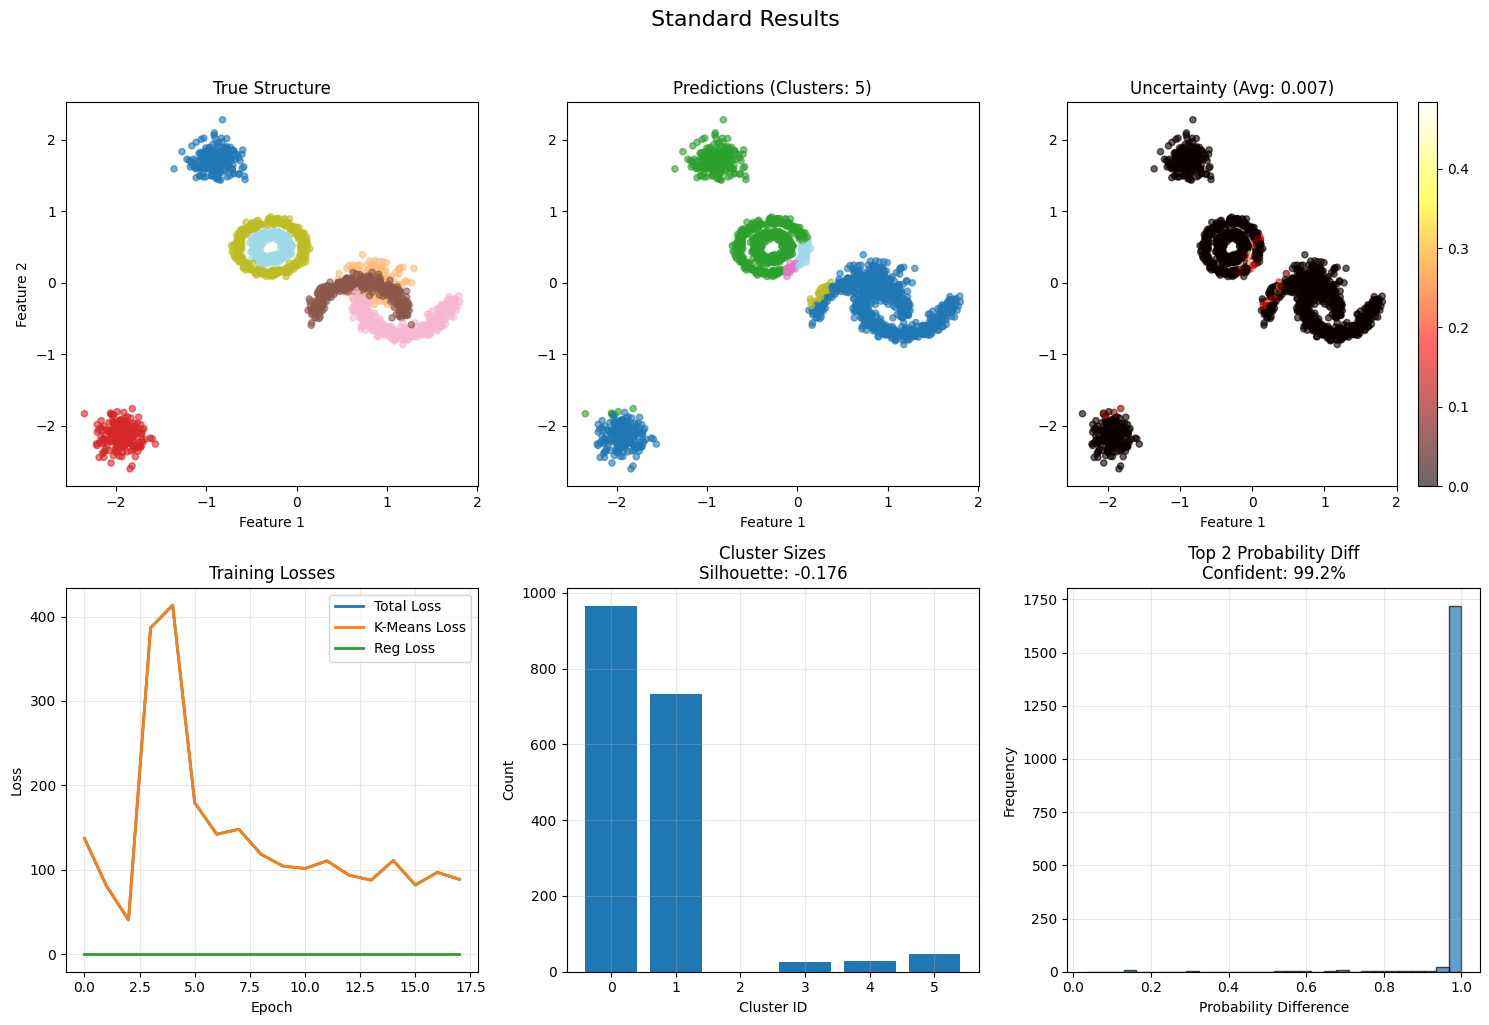


Summary for Standard:
  • Found clusters: 5
  • Silhouette score: -0.176
  • Davies-Bouldin: 1.739
  • Average uncertainty: 0.007
  • Confident predictions: 99.2%
  • Cluster distribution: {0: np.int64(965), 1: np.int64(733), 2: np.int64(0), 3: np.int64(26), 4: np.int64(29), 5: np.int64(47)}

Testing Attention
Epoch 10/80: Total=43.1533, K-Means=43.1499, Reg=0.0034, LR=0.010000
Epoch 20/80: Total=7.8709, K-Means=7.8454, Reg=0.0255, LR=0.005000
Epoch 30/80: Total=5.0626, K-Means=5.0321, Reg=0.0306, LR=0.005000
Epoch 40/80: Total=4.7650, K-Means=4.7582, Reg=0.0068, LR=0.002500
Epoch 50/80: Total=3.0326, K-Means=3.0222, Reg=0.0103, LR=0.001250
Epoch 60/80: Total=0.6374, K-Means=0.6232, Reg=0.0142, LR=0.001250
Epoch 70/80: Total=0.0902, K-Means=0.0902, Reg=0.0000, LR=0.000625
Epoch 80/80: Total=0.8089, K-Means=0.7995, Reg=0.0095, LR=0.000625
Found 2 clusters: [0 4]


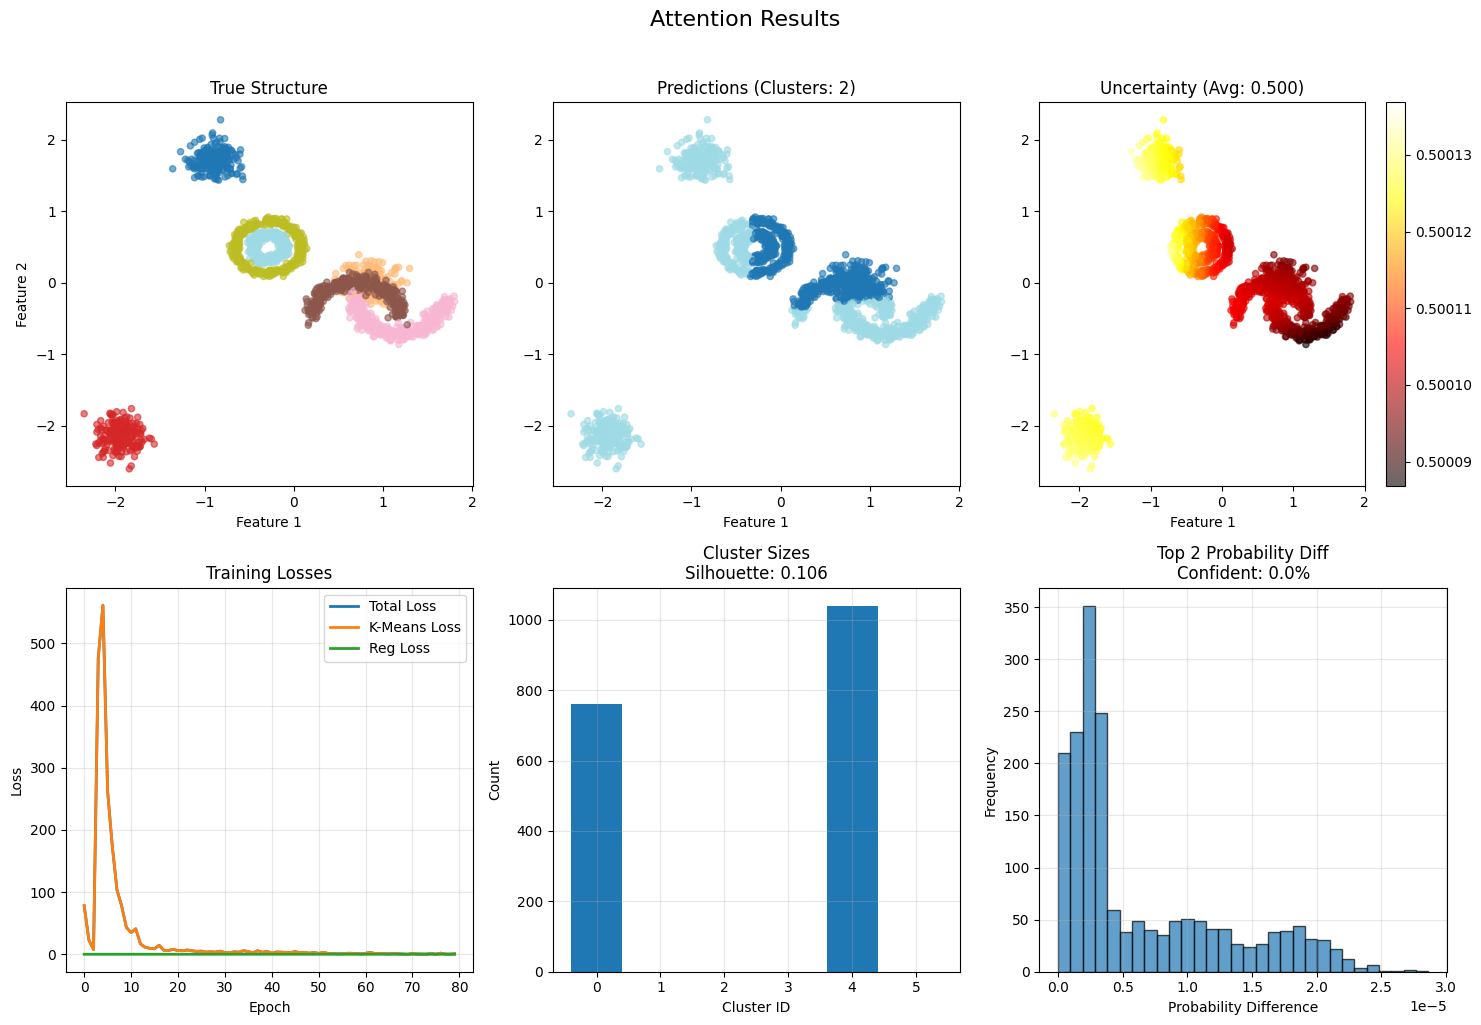


Summary for Attention:
  • Found clusters: 2
  • Silhouette score: 0.106
  • Davies-Bouldin: 3.074
  • Average uncertainty: 0.500
  • Confident predictions: 0.0%
  • Cluster distribution: {0: np.int64(761), 1: np.int64(0), 2: np.int64(0), 3: np.int64(0), 4: np.int64(1039), 5: np.int64(0)}

Testing Deep
Epoch 10/80: Total=0.0997, K-Means=0.0001, Reg=0.0996, LR=0.010000
Epoch 20/80: Total=0.1004, K-Means=0.0001, Reg=0.1003, LR=0.010000
Epoch 30/80: Total=0.1013, K-Means=0.0000, Reg=0.1013, LR=0.005000
Early stopping at epoch 33
Found 1 clusters: [0]


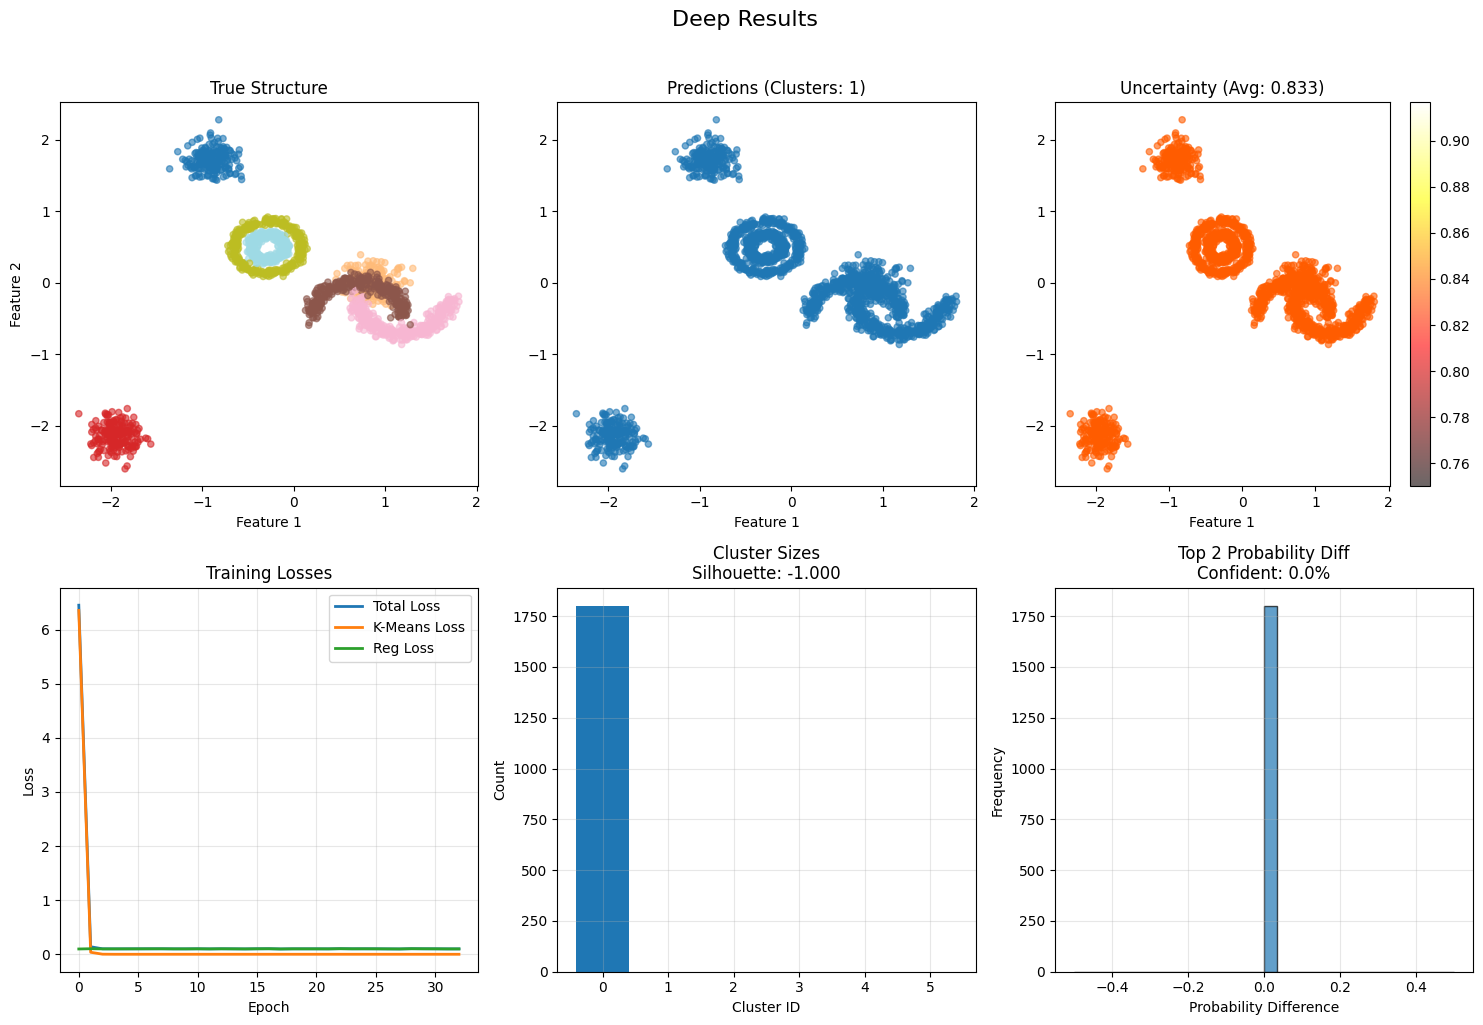


Summary for Deep:
  • Found clusters: 1
  • Silhouette score: -1.000
  • Davies-Bouldin: inf
  • Average uncertainty: 0.833
  • Confident predictions: 0.0%
  • Cluster distribution: {0: np.int64(1800), 1: np.int64(0), 2: np.int64(0), 3: np.int64(0), 4: np.int64(0), 5: np.int64(0)}

Testing Fuzzy
Epoch 10/80: Total=6.2412, K-Means=6.2412, Reg=0.0000, LR=0.010000
Epoch 20/80: Total=6.1519, K-Means=6.1519, Reg=0.0000, LR=0.010000
Epoch 30/80: Total=6.0666, K-Means=6.0666, Reg=0.0000, LR=0.010000
Epoch 40/80: Total=6.0520, K-Means=6.0520, Reg=0.0000, LR=0.010000
Epoch 50/80: Total=6.0845, K-Means=6.0845, Reg=0.0000, LR=0.010000
Epoch 60/80: Total=6.0170, K-Means=6.0170, Reg=0.0000, LR=0.005000
Epoch 70/80: Total=6.0038, K-Means=6.0038, Reg=0.0000, LR=0.005000
Epoch 80/80: Total=6.0121, K-Means=6.0121, Reg=0.0000, LR=0.002500
Found 6 clusters: [0 1 2 3 4 5]


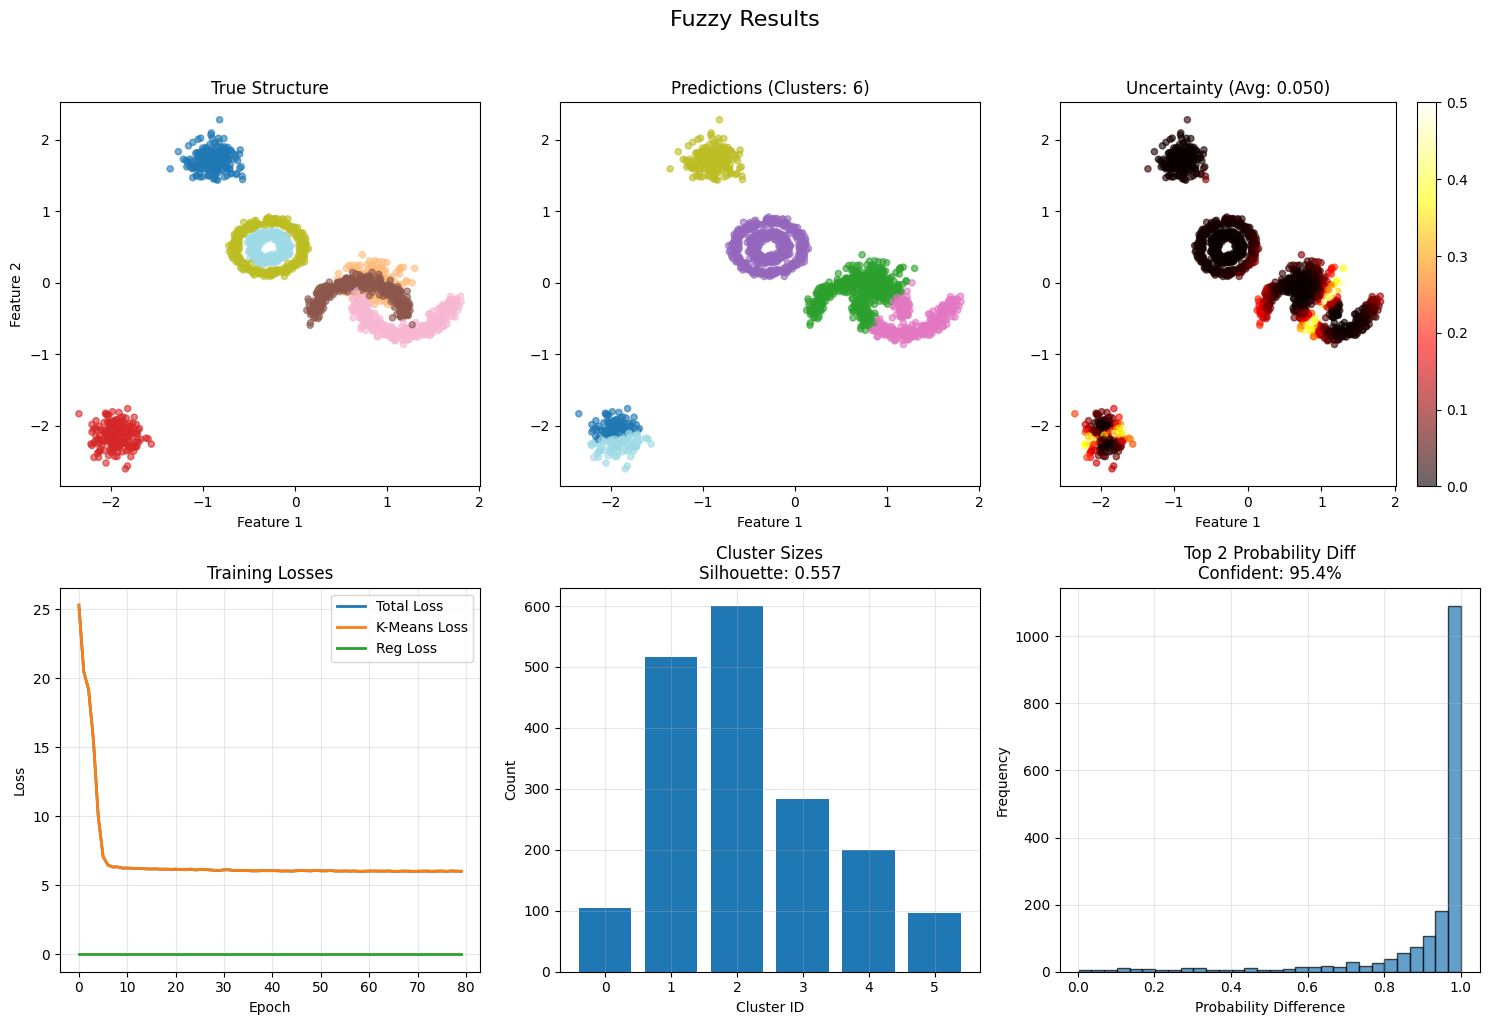


Summary for Fuzzy:
  • Found clusters: 6
  • Silhouette score: 0.557
  • Davies-Bouldin: 0.792
  • Average uncertainty: 0.050
  • Confident predictions: 95.4%
  • Cluster distribution: {0: np.int64(104), 1: np.int64(516), 2: np.int64(600), 3: np.int64(284), 4: np.int64(200), 5: np.int64(96)}

Testing Kernel
Epoch 10/80: Total=-440005628.0647, K-Means=-440005628.0647, Reg=0.0000, LR=0.010000
Epoch 20/80: Total=-10537047869973883518976.0000, K-Means=-10537047869973883518976.0000, Reg=0.0000, LR=0.010000
Epoch 30/80: Total=-5522031168860338520064.0000, K-Means=-5522031168860338520064.0000, Reg=0.0000, LR=0.010000
Epoch 40/80: Total=-5349241830465337294848.0000, K-Means=-5349241830465337294848.0000, Reg=0.0000, LR=0.005000
Early stopping at epoch 42
Found 5 clusters: [0 1 2 4 5]


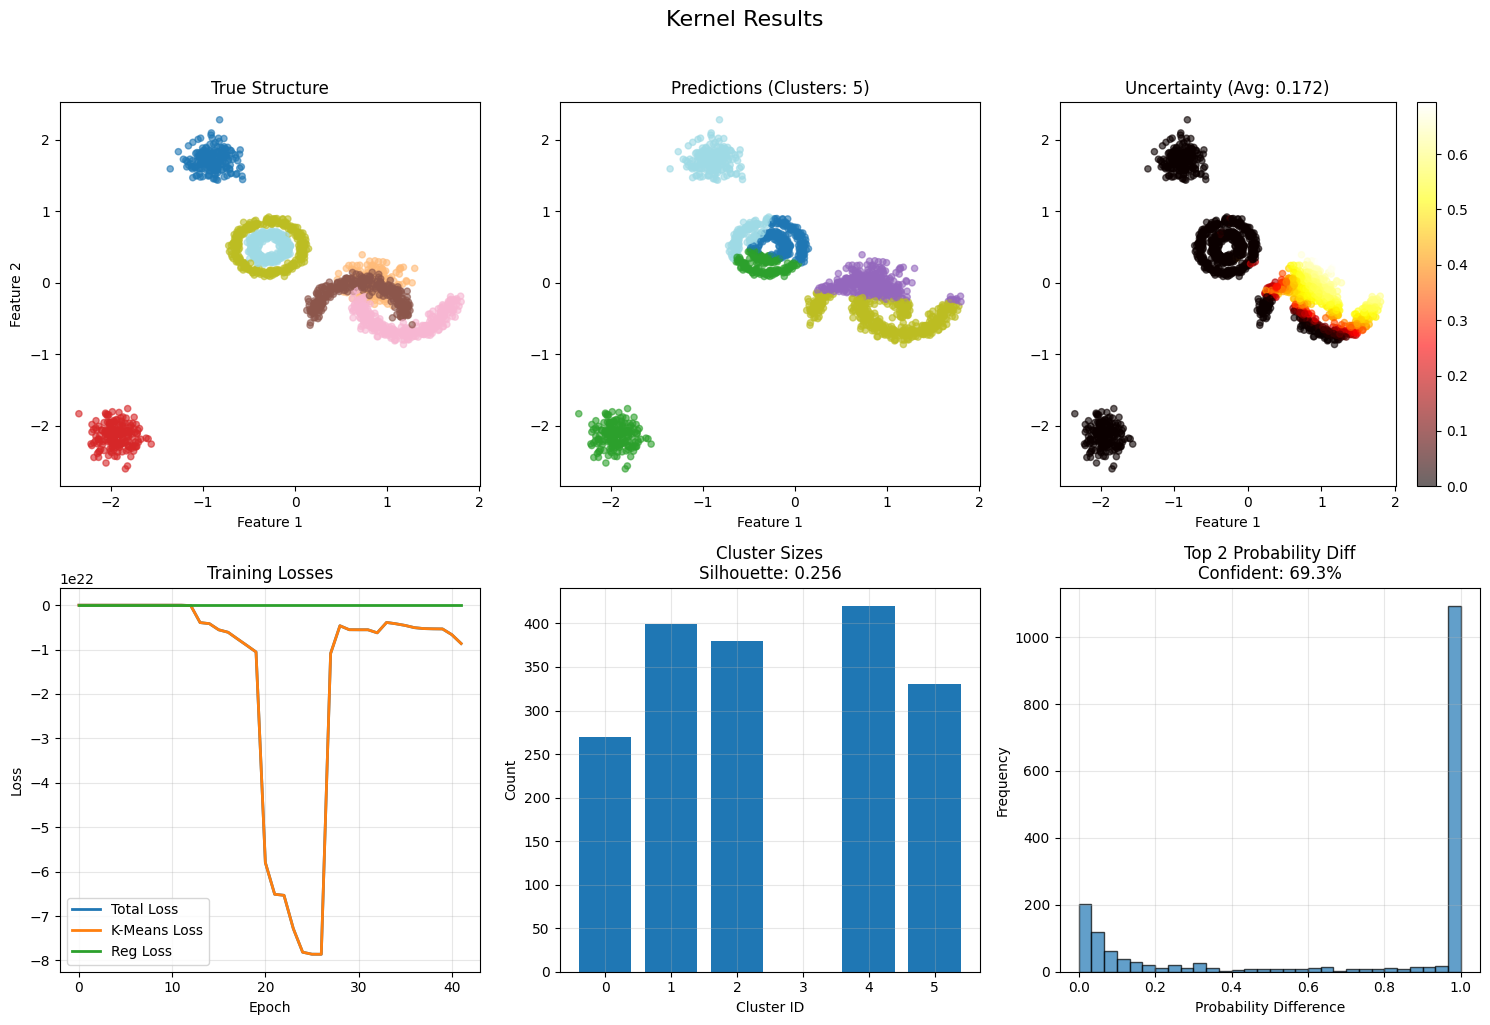


Summary for Kernel:
  • Found clusters: 5
  • Silhouette score: 0.256
  • Davies-Bouldin: 1.082
  • Average uncertainty: 0.172
  • Confident predictions: 69.3%
  • Cluster distribution: {0: np.int64(270), 1: np.int64(399), 2: np.int64(380), 3: np.int64(0), 4: np.int64(420), 5: np.int64(331)}

Testing Ensemble
Epoch 10/80: Total=118.9300, K-Means=118.9300, Reg=0.0000, LR=0.010000
Early stopping at epoch 18
Found 1 clusters: [5]


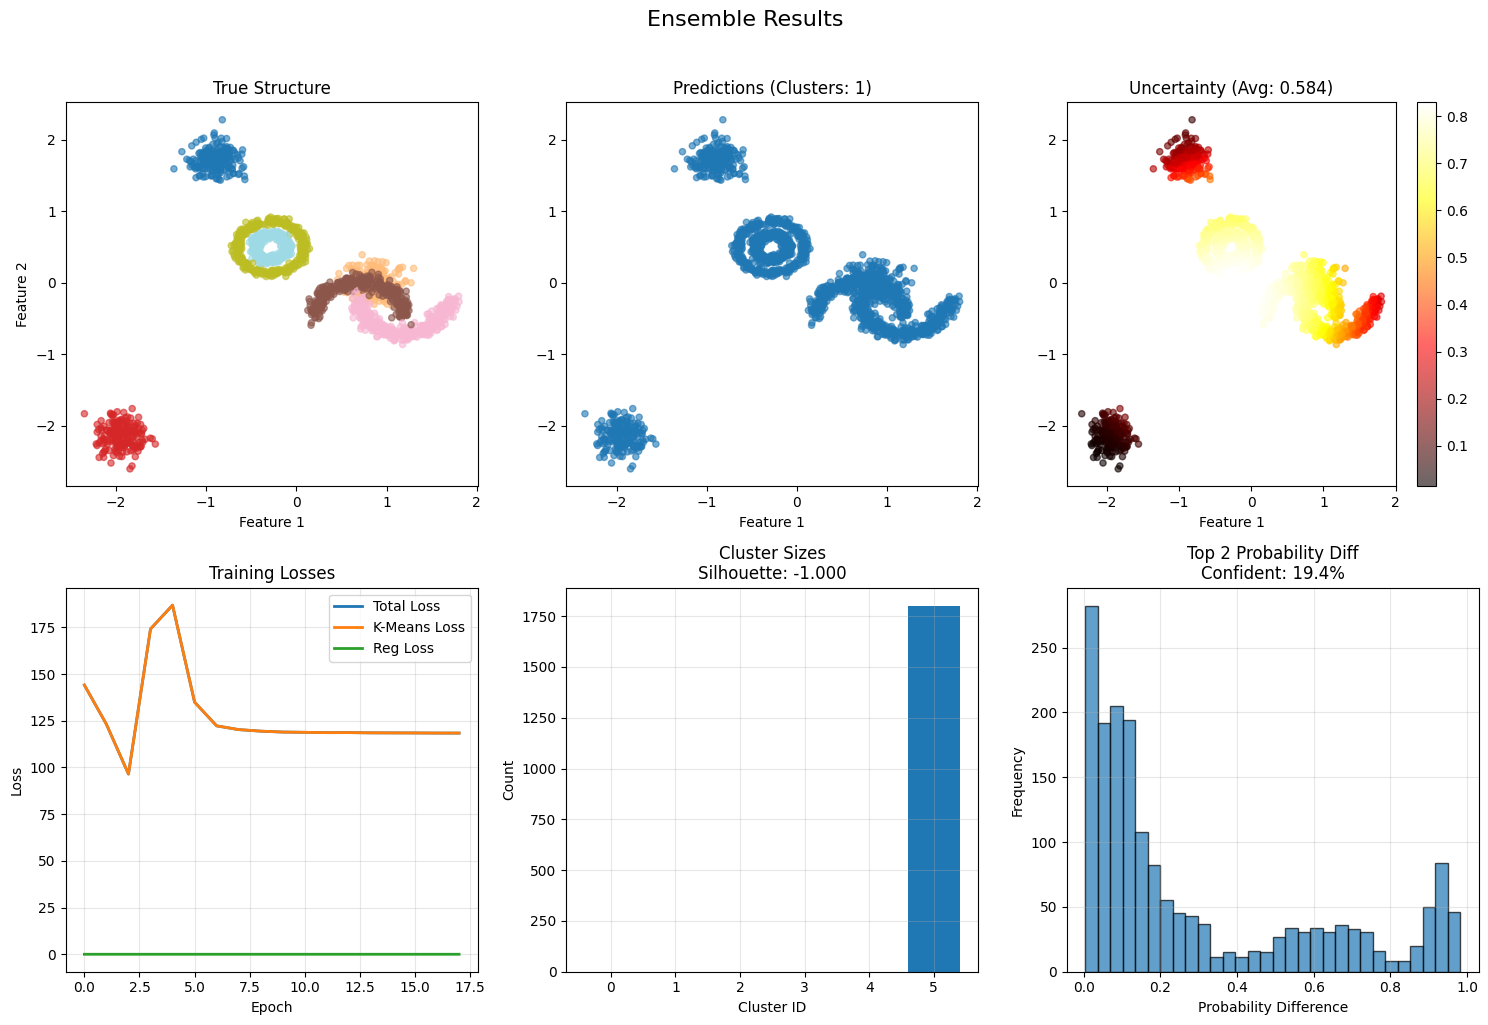


Summary for Ensemble:
  • Found clusters: 1
  • Silhouette score: -1.000
  • Davies-Bouldin: inf
  • Average uncertainty: 0.584
  • Confident predictions: 19.4%
  • Cluster distribution: {0: np.int64(0), 1: np.int64(0), 2: np.int64(0), 3: np.int64(0), 4: np.int64(0), 5: np.int64(1800)}

Testing Dynamic
Epoch 10/80: Total=122.1870, K-Means=122.1483, Reg=0.0387, LR=0.010000
Early stopping at epoch 18
Found 4 clusters: [0 1 2 4]


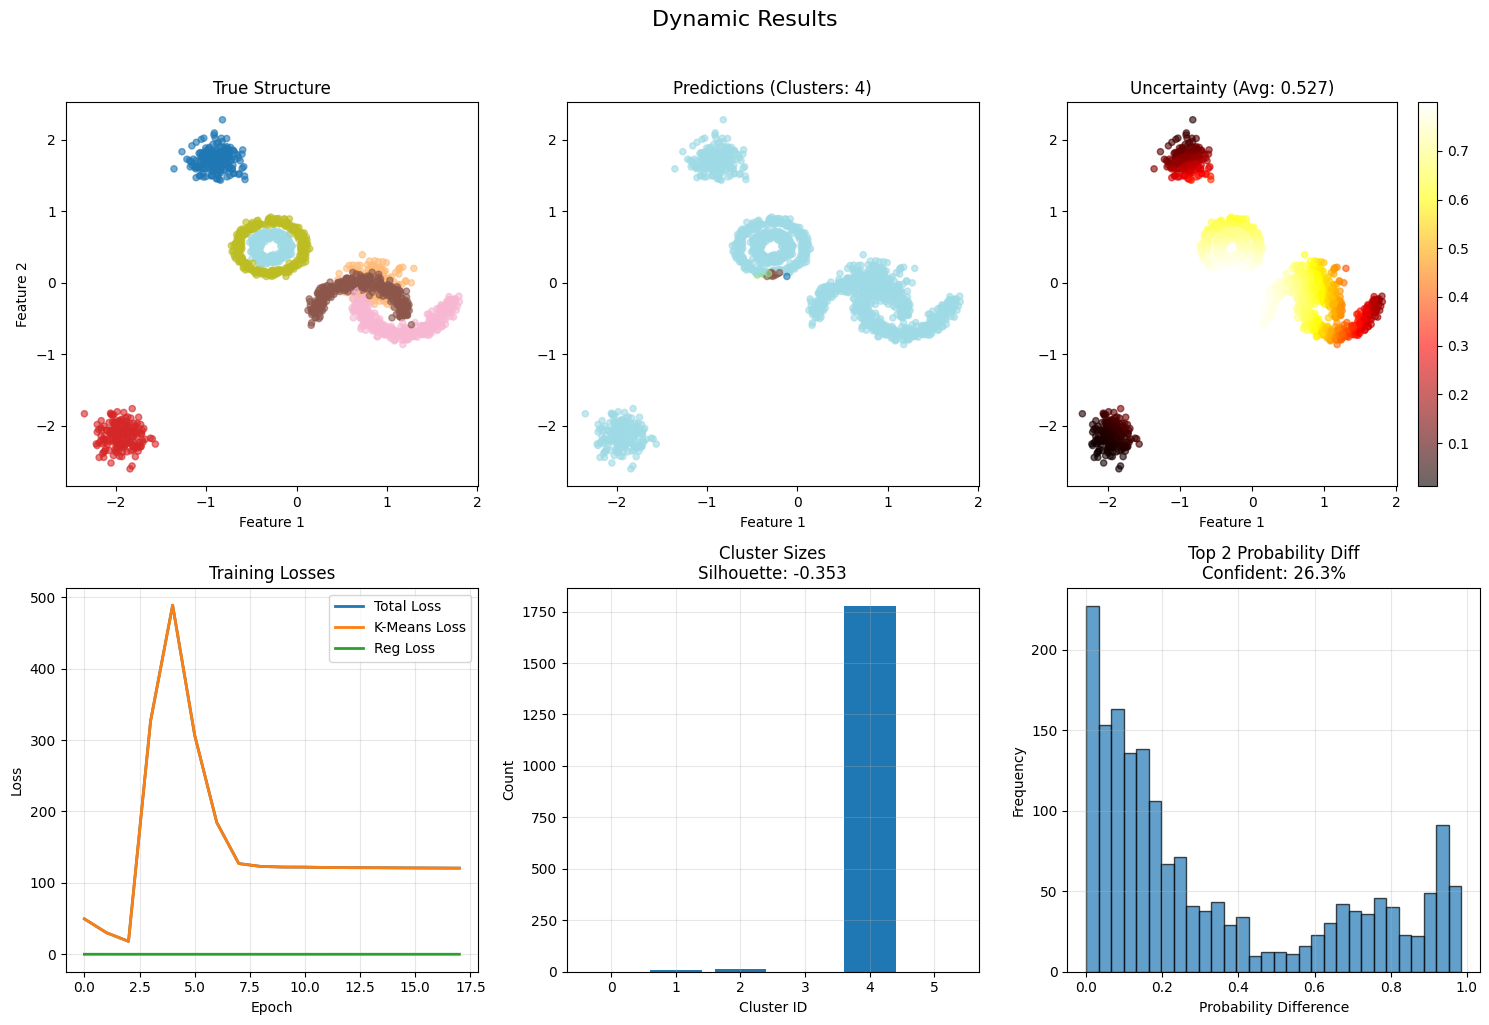


Summary for Dynamic:
  • Found clusters: 4
  • Silhouette score: -0.353
  • Davies-Bouldin: 5.774
  • Average uncertainty: 0.527
  • Confident predictions: 26.3%
  • Cluster distribution: {0: np.int64(1), 1: np.int64(7), 2: np.int64(15), 3: np.int64(0), 4: np.int64(1777), 5: np.int64(0)}

Testing Sparse
Epoch 10/80: Total=57.9467, K-Means=57.9467, Reg=0.0000, LR=0.010000
Early stopping at epoch 18
Found 5 clusters: [0 1 2 4 5]


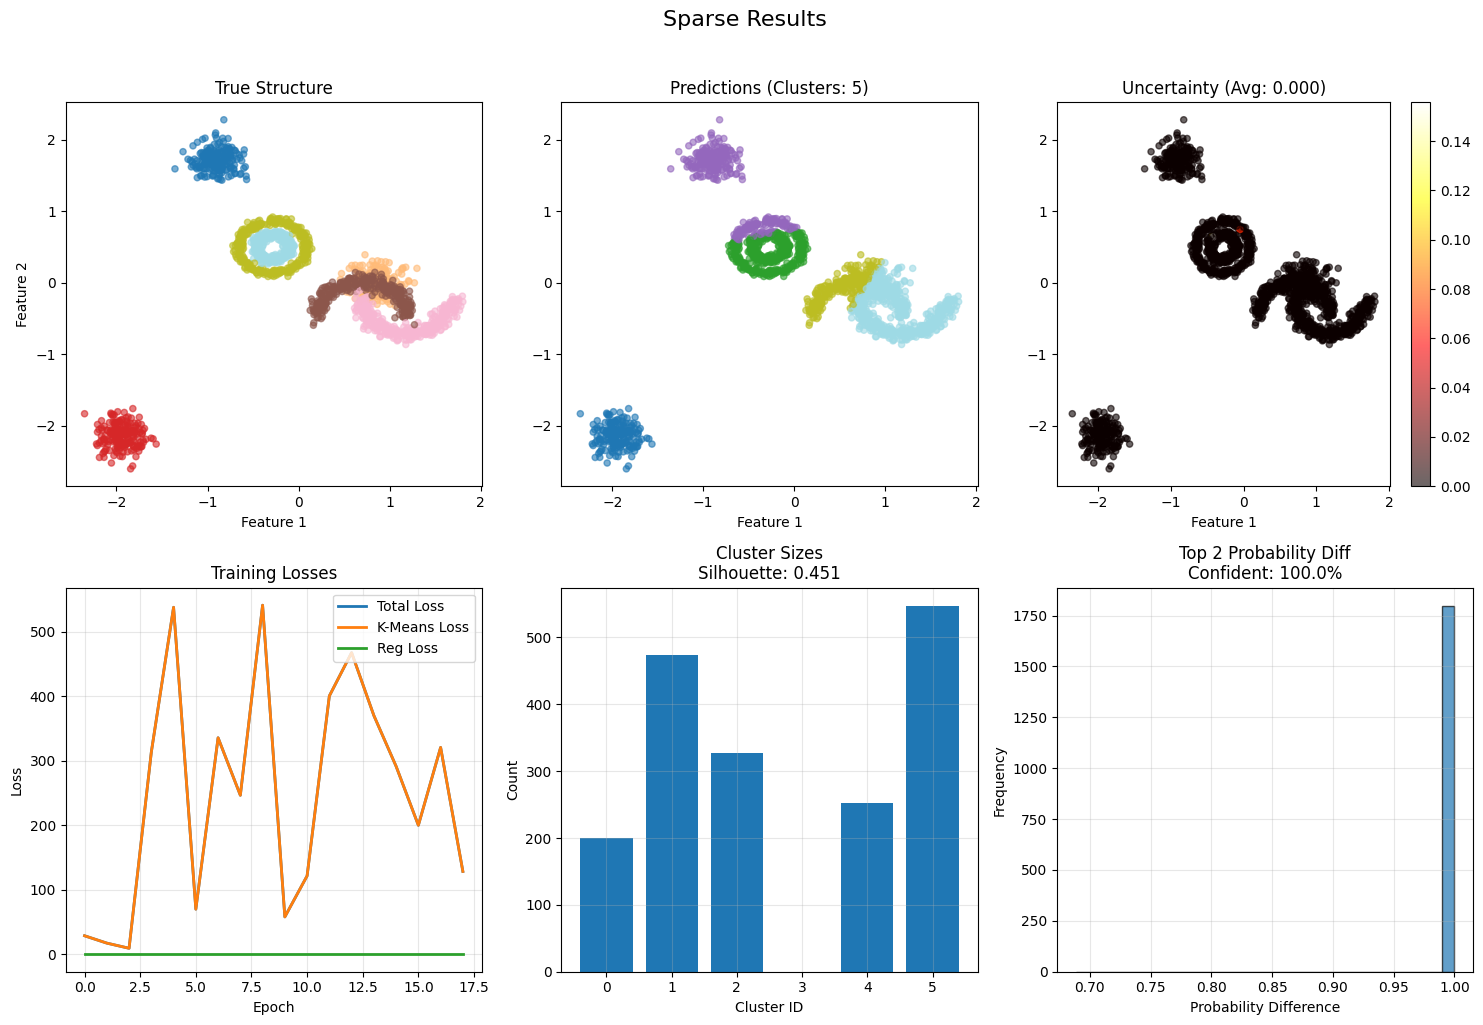


Summary for Sparse:
  • Found clusters: 5
  • Silhouette score: 0.451
  • Davies-Bouldin: 0.734
  • Average uncertainty: 0.000
  • Confident predictions: 100.0%
  • Cluster distribution: {0: np.int64(200), 1: np.int64(473), 2: np.int64(327), 3: np.int64(0), 4: np.int64(253), 5: np.int64(547)}


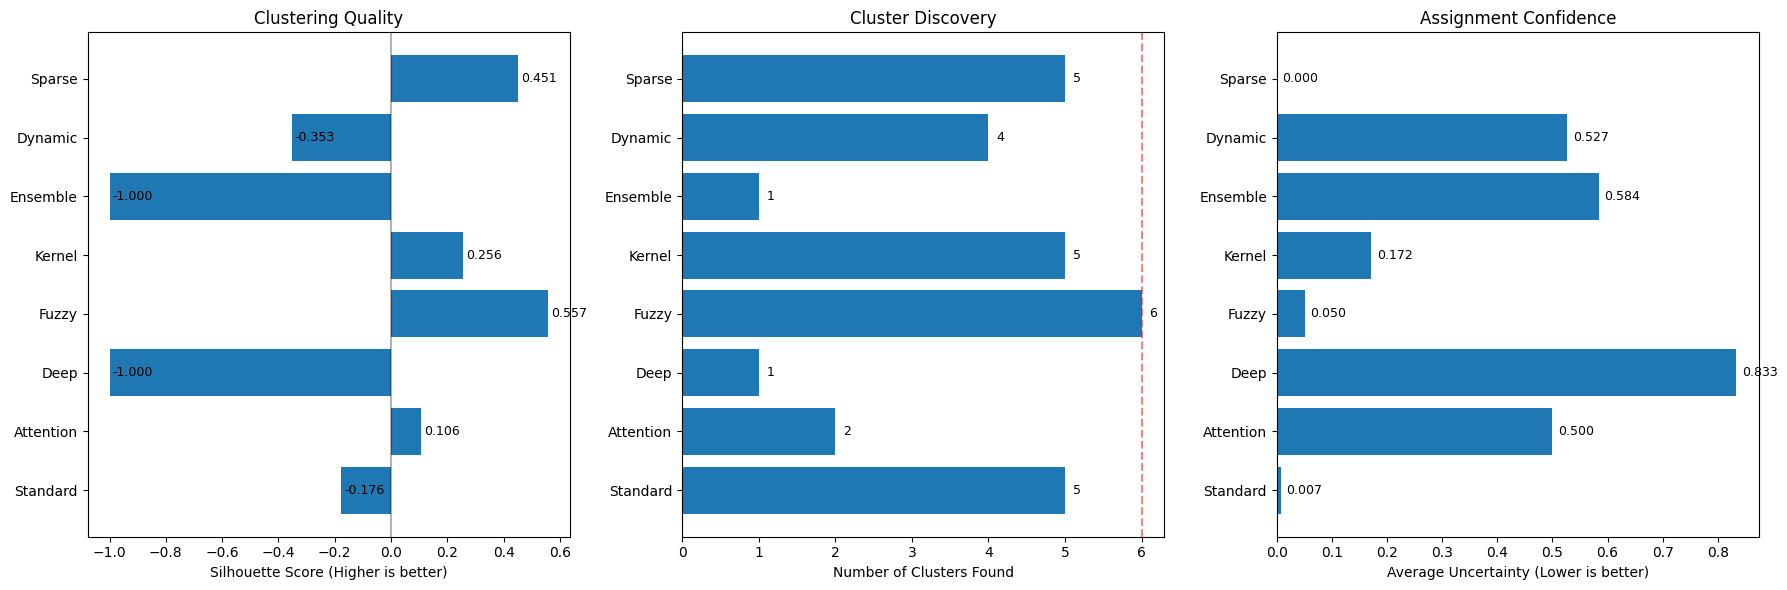


FINAL RANKING (by Silhouette Score):
1. Fuzzy           | Silhouette: 0.557 | Clusters: 6 | Uncertainty: 0.050 | Confident: 95.4%
2. Sparse          | Silhouette: 0.451 | Clusters: 5 | Uncertainty: 0.000 | Confident: 100.0%
3. Kernel          | Silhouette: 0.256 | Clusters: 5 | Uncertainty: 0.172 | Confident: 69.3%
4. Attention       | Silhouette: 0.106 | Clusters: 2 | Uncertainty: 0.500 | Confident: 0.0%
5. Standard        | Silhouette: -0.176 | Clusters: 5 | Uncertainty: 0.007 | Confident: 99.2%
6. Dynamic         | Silhouette: -0.353 | Clusters: 4 | Uncertainty: 0.527 | Confident: 26.3%
7. Deep            | Silhouette: -1.000 | Clusters: 1 | Uncertainty: 0.833 | Confident: 0.0%
8. Ensemble        | Silhouette: -1.000 | Clusters: 1 | Uncertainty: 0.584 | Confident: 19.4%

ABLATION STUDY: Effect of Temperature

Testing with temperature=0.1
Epoch 10/60: Total=122.1416, K-Means=122.1416, Reg=0.0000, LR=0.010000
Epoch 20/60: Total=92.7418, K-Means=92.7302, Reg=0.0115, LR=0.010000
Epoch 

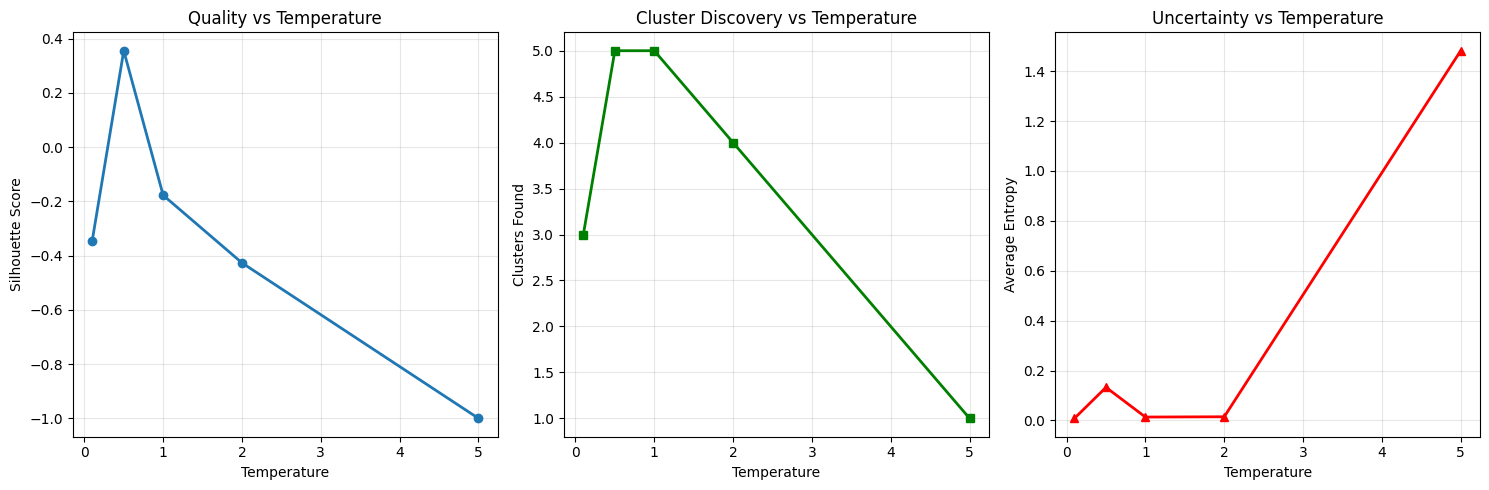


EXPERIMENT COMPLETE


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

def initialize_centroids(X, n_clusters):
    """Better centroid initialization using k-means++"""
    indices = []
    first_idx = torch.randint(0, X.shape[0], (1,)).item()
    indices.append(first_idx)
    centroids = [X[first_idx]]

    for _ in range(1, n_clusters):
        dist_sq = torch.zeros(X.shape[0])
        for centroid in centroids:
            dist_sq += torch.sum((X - centroid) ** 2, dim=1)
        probs = dist_sq / dist_sq.sum()
        idx = torch.multinomial(probs, 1).item()
        indices.append(idx)
        centroids.append(X[idx])

    return torch.stack(centroids)

class SoftKMeansLayer(nn.Module):
    def __init__(self, input_dim, num_clusters, temperature=1.0, X=None):
        super().__init__()
        self.num_clusters = num_clusters
        self.temperature = nn.Parameter(torch.tensor([temperature]))

        if X is not None and len(X) >= num_clusters:
            centroids = initialize_centroids(X, num_clusters)
            self.centroids = nn.Parameter(centroids)
        else:
            self.centroids = nn.Parameter(torch.randn(num_clusters, input_dim) * 0.1)

        self.centroid_logits = nn.Parameter(torch.ones(num_clusters))

    def forward(self, x):
        x_expanded = x.unsqueeze(1)
        centroids_expanded = self.centroids.unsqueeze(0)
        distances = torch.sum((x_expanded - centroids_expanded) ** 2, dim=2)

        cluster_weights = F.softmax(self.centroid_logits, dim=0)
        weighted_distances = distances * cluster_weights.unsqueeze(0)

        logits = -weighted_distances / (self.temperature + 1e-8)
        responsibilities = F.softmax(logits, dim=1)

        entropy = -torch.sum(responsibilities.mean(dim=0) * torch.log(responsibilities.mean(dim=0) + 1e-10))
        reg_loss = torch.relu(0.1 - entropy)

        return responsibilities, distances, reg_loss

class AttentionSoftKMeans(nn.Module):
    def __init__(self, input_dim, num_clusters, temperature=1.0, X=None):
        super().__init__()
        self.num_clusters = num_clusters

        self.attention = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.Tanh(),
            nn.Linear(32, input_dim),
            nn.Sigmoid()
        )

        self.soft_kmeans = SoftKMeansLayer(input_dim, num_clusters, temperature, X)

    def forward(self, x):
        attn_weights = self.attention(x)
        weighted_x = x * attn_weights
        responsibilities, distances, reg_loss = self.soft_kmeans(weighted_x)
        return responsibilities, distances, reg_loss

class DeepSoftKMeans(nn.Module):
    def __init__(self, input_dim, num_clusters, hidden_dims=[64, 32], temperature=1.0, X=None):
        super().__init__()
        self.num_clusters = num_clusters

        layers = []
        prev_dim = input_dim
        for dim in hidden_dims:
            layers.extend([nn.Linear(prev_dim, dim), nn.ReLU()])
            prev_dim = dim

        self.encoder = nn.Sequential(*layers)
        self.soft_kmeans = SoftKMeansLayer(prev_dim, num_clusters, temperature)

        decoder_layers = []
        for dim in reversed(hidden_dims):
            decoder_layers.extend([nn.Linear(prev_dim, dim), nn.ReLU()])
            prev_dim = dim
        decoder_layers.append(nn.Linear(prev_dim, input_dim))
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        features = self.encoder(x)
        responsibilities, distances, reg_loss = self.soft_kmeans(features)
        reconstructed = self.decoder(features)
        recon_loss = F.mse_loss(reconstructed, x)
        return responsibilities, distances, reg_loss + 0.1 * recon_loss

class FuzzyKMeans(nn.Module):
    def __init__(self, input_dim, num_clusters, m=2.0, X=None):
        super().__init__()
        self.num_clusters = num_clusters
        self.m = m

        if X is not None and len(X) >= num_clusters:
            centroids = initialize_centroids(X, num_clusters)
            self.centroids = nn.Parameter(centroids)
        else:
            self.centroids = nn.Parameter(torch.randn(num_clusters, input_dim) * 0.1)

        self.cluster_weights = nn.Parameter(torch.ones(num_clusters))

    def forward(self, x):
        x_expanded = x.unsqueeze(1)
        centroids_expanded = self.centroids.unsqueeze(0)
        distances = torch.sum((x_expanded - centroids_expanded) ** 2, dim=2)

        with torch.no_grad():
            eps = 1e-10
            if self.m > 1.0:
                power = 2.0 / (self.m - 1)
                weights = 1.0 / (distances + eps)
                weights = weights ** power
                responsibilities = weights / (weights.sum(dim=1, keepdim=True) + eps)
            else:
                responsibilities = (distances == distances.min(dim=1, keepdim=True)[0]).float()

        cluster_weights = torch.sigmoid(self.cluster_weights)
        weighted_resp = responsibilities * cluster_weights.unsqueeze(0)
        weighted_resp = weighted_resp / (weighted_resp.sum(dim=1, keepdim=True) + eps)

        entropy = -torch.sum(weighted_resp.mean(dim=0) * torch.log(weighted_resp.mean(dim=0) + eps))
        reg_loss = torch.relu(0.2 - entropy)

        return weighted_resp, distances, reg_loss

class KernelSoftKMeans(nn.Module):
    def __init__(self, input_dim, num_clusters, temperature=1.0, gamma=1.0, X=None):
        super().__init__()
        self.num_clusters = num_clusters
        self.gamma = nn.Parameter(torch.tensor([gamma]))
        self.temperature = nn.Parameter(torch.tensor([temperature]))

        if X is not None and len(X) >= num_clusters:
            centroids = initialize_centroids(X, num_clusters)
            self.centroids = nn.Parameter(centroids)
        else:
            self.centroids = nn.Parameter(torch.randn(num_clusters, input_dim) * 0.1)

        self.cluster_logits = nn.Parameter(torch.ones(num_clusters))

    def rbf_kernel(self, x, y):
        x_norm = (x ** 2).sum(dim=1).unsqueeze(1)
        y_norm = (y ** 2).sum(dim=1).unsqueeze(0)
        pairwise_dist = x_norm + y_norm - 2 * torch.mm(x, y.t())
        return torch.exp(-self.gamma * pairwise_dist)

    def forward(self, x):
        K_x = self.rbf_kernel(x, x)
        K_xc = self.rbf_kernel(x, self.centroids)
        K_cc = self.rbf_kernel(self.centroids, self.centroids)

        distances = torch.diag(K_x).unsqueeze(1) - 2 * K_xc + torch.diag(K_cc).unsqueeze(0)

        cluster_weights = F.softmax(self.cluster_logits, dim=0)
        weighted_dist = distances * cluster_weights.unsqueeze(0)

        logits = -weighted_dist / (self.temperature + 1e-8)
        responsibilities = F.softmax(logits, dim=1)

        entropy = -torch.sum(responsibilities.mean(dim=0) * torch.log(responsibilities.mean(dim=0) + 1e-10))
        reg_loss = torch.relu(0.1 - entropy)

        return responsibilities, distances, reg_loss

class EnsembleSoftKMeans(nn.Module):
    def __init__(self, input_dim, num_clusters, n_models=3, temperature=1.0, X=None):
        super().__init__()
        self.models = nn.ModuleList()
        for i in range(n_models):
            if i == 0:
                model = SoftKMeansLayer(input_dim, num_clusters, temperature, X)
            else:
                model = SoftKMeansLayer(input_dim, num_clusters, temperature * (1 + 0.1 * i))
            self.models.append(model)

    def forward(self, x):
        all_resp = []
        all_dist = []
        all_reg = []

        for model in self.models:
            resp, dist, reg = model(x)
            all_resp.append(resp)
            all_dist.append(dist)
            all_reg.append(reg)

        avg_resp = torch.stack(all_resp).mean(dim=0)
        avg_dist = torch.stack(all_dist).mean(dim=0)
        avg_reg = torch.stack(all_reg).mean(dim=0)

        return avg_resp, avg_dist, avg_reg

class DynamicSoftKMeans(nn.Module):
    def __init__(self, input_dim, max_clusters=10, temperature=1.0, X=None):
        super().__init__()
        self.max_clusters = max_clusters

        if X is not None and len(X) >= max_clusters:
            centroids = initialize_centroids(X, max_clusters)
            self.centroids = nn.Parameter(centroids)
        else:
            self.centroids = nn.Parameter(torch.randn(max_clusters, input_dim) * 0.1)

        self.cluster_logits = nn.Parameter(torch.zeros(max_clusters))
        self.temperature = nn.Parameter(torch.tensor([temperature]))

    def forward(self, x):
        cluster_probs = torch.sigmoid(self.cluster_logits)
        active_mask = cluster_probs > 0.3

        if active_mask.sum() < 2:
            top2 = torch.topk(cluster_probs, 2).indices
            active_mask = torch.zeros_like(active_mask)
            active_mask[top2] = True

        active_centroids = self.centroids[active_mask]

        x_expanded = x.unsqueeze(1)
        centroids_expanded = active_centroids.unsqueeze(0)
        distances = torch.sum((x_expanded - centroids_expanded) ** 2, dim=2)

        active_probs = cluster_probs[active_mask]
        weighted_dist = distances * active_probs.unsqueeze(0)

        logits = -weighted_dist / (self.temperature + 1e-8)
        responsibilities = F.softmax(logits, dim=1)

        cluster_usage = responsibilities.mean(dim=0)
        entropy = -torch.sum(cluster_usage * torch.log(cluster_usage + 1e-10))
        reg_loss = torch.relu(0.2 - entropy) + 0.1 * (1 - cluster_probs.mean())

        return responsibilities, distances, reg_loss

class SparseSoftKMeans(nn.Module):
    def __init__(self, input_dim, num_clusters, temperature=1.0, sparsity=0.3, X=None):
        super().__init__()
        self.num_clusters = num_clusters
        self.sparsity = sparsity

        if X is not None and len(X) >= num_clusters:
            centroids = initialize_centroids(X, num_clusters)
            self.centroids = nn.Parameter(centroids)
        else:
            self.centroids = nn.Parameter(torch.randn(num_clusters, input_dim) * 0.1)

        self.temperature = nn.Parameter(torch.tensor([temperature]))
        self.selector = nn.Parameter(torch.ones(num_clusters))

    def forward(self, x):
        x_expanded = x.unsqueeze(1)
        centroids_expanded = self.centroids.unsqueeze(0)
        distances = torch.sum((x_expanded - centroids_expanded) ** 2, dim=2)

        selector = torch.sigmoid(self.selector)
        masked_distances = distances * selector.unsqueeze(0)

        logits = -masked_distances / (self.temperature + 1e-8)
        responsibilities = F.softmax(logits, dim=1)

        topk = max(1, int(self.num_clusters * (1 - self.sparsity)))
        topk_values, _ = torch.topk(responsibilities, topk, dim=1)
        threshold = topk_values[:, -1].unsqueeze(1)
        sparse_resp = responsibilities * (responsibilities >= threshold).float()
        sparse_resp = sparse_resp / (sparse_resp.sum(dim=1, keepdim=True) + 1e-10)

        reg_loss = torch.relu(0.5 - selector.mean())

        return sparse_resp, distances, reg_loss

class Trainer:
    def __init__(self, model, lr=0.01, patience=10):
        self.model = model.to(device)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', patience=patience//2, factor=0.5
        )
        self.patience = patience
        self.best_loss = float('inf')
        self.counter = 0

    def train_step(self, x_batch):
        self.optimizer.zero_grad()
        responsibilities, distances, reg_loss = self.model(x_batch)

        kmeans_loss = torch.sum(responsibilities * distances)
        total_loss = kmeans_loss + reg_loss

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        self.optimizer.step()

        return total_loss.item(), kmeans_loss.item(), reg_loss.item()

    def train(self, data_loader, epochs=100):
        losses = {'total': [], 'kmeans': [], 'reg': []}

        for epoch in range(epochs):
            epoch_total = 0
            epoch_kmeans = 0
            epoch_reg = 0

            for x_batch, _ in data_loader:
                x_batch = x_batch.to(device)
                total, kmeans, reg = self.train_step(x_batch)
                epoch_total += total
                epoch_kmeans += kmeans
                epoch_reg += reg

            avg_total = epoch_total / len(data_loader)
            avg_kmeans = epoch_kmeans / len(data_loader)
            avg_reg = epoch_reg / len(data_loader)

            losses['total'].append(avg_total)
            losses['kmeans'].append(avg_kmeans)
            losses['reg'].append(avg_reg)

            self.scheduler.step(avg_total)

            current_lr = self.optimizer.param_groups[0]['lr']

            if avg_total < self.best_loss:
                self.best_loss = avg_total
                self.counter = 0
            else:
                self.counter += 1
                if self.counter >= self.patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}: "
                      f"Total={avg_total:.4f}, "
                      f"K-Means={avg_kmeans:.4f}, "
                      f"Reg={avg_reg:.4f}, "
                      f"LR={current_lr:.6f}")

        return losses

def create_complex_dataset(n_samples=1500, n_clusters=6):
    np.random.seed(42)

    X1, y1 = make_blobs(n_samples=n_samples//3, centers=3, cluster_std=0.6, random_state=42)

    X2, y2 = make_moons(n_samples=n_samples//3, noise=0.1, random_state=42)
    X2 = X2 * 2 + np.array([4, 0])

    X3, y3 = make_circles(n_samples=n_samples//3, factor=0.5, noise=0.05, random_state=42)
    X3 = X3 * 1.5 + np.array([0, 4])

    X = np.vstack([X1, X2, X3])
    y = np.concatenate([y1, y2 + 3, y3 + 5])

    X += np.random.randn(*X.shape) * 0.1

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    X_tensor = torch.FloatTensor(X).to(device)
    y_tensor = torch.LongTensor(y).to(device)

    dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

    return X_tensor, y_tensor, data_loader, X

def test_variation(variation_name, model_class, X, data_loader, true_labels, X_raw, epochs=80):
    print(f"\n{'='*60}")
    print(f"Testing {variation_name}")
    print('='*60)

    model = model_class(X.shape[1], 6, X=X).to(device)

    trainer = Trainer(model, lr=0.01, patience=15)
    losses = trainer.train(data_loader, epochs=epochs)

    with torch.no_grad():
        responsibilities, distances, _ = model(X)
        predictions = torch.argmax(responsibilities, dim=1).cpu().numpy()
        soft_probs = responsibilities.cpu().numpy()

        unique_preds = np.unique(predictions)
        print(f"Found {len(unique_preds)} clusters: {unique_preds}")

        if len(unique_preds) > 1:
            silhouette = silhouette_score(X_raw, predictions)
            davies = davies_bouldin_score(X_raw, predictions)
        else:
            silhouette = -1.0
            davies = float('inf')

        cluster_sizes = np.bincount(predictions, minlength=6)
        cluster_distribution = dict(enumerate(cluster_sizes))

        uncertainty = 1 - np.max(soft_probs, axis=1)
        avg_uncertainty = np.mean(uncertainty)
        confident_rate = np.mean(uncertainty < 0.3)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    axes[0, 0].scatter(X_raw[:, 0], X_raw[:, 1], c=true_labels, cmap='tab20', alpha=0.6, s=20)
    axes[0, 0].set_title("True Structure")
    axes[0, 0].set_xlabel("Feature 1")
    axes[0, 0].set_ylabel("Feature 2")

    scatter = axes[0, 1].scatter(X_raw[:, 0], X_raw[:, 1], c=predictions, cmap='tab20', alpha=0.6, s=20)
    axes[0, 1].set_title(f"Predictions (Clusters: {len(unique_preds)})")
    axes[0, 1].set_xlabel("Feature 1")

    im = axes[0, 2].scatter(X_raw[:, 0], X_raw[:, 1], c=uncertainty, cmap='hot', alpha=0.6, s=20)
    axes[0, 2].set_title(f"Uncertainty (Avg: {avg_uncertainty:.3f})")
    axes[0, 2].set_xlabel("Feature 1")
    plt.colorbar(im, ax=axes[0, 2])

    axes[1, 0].plot(losses['total'], label='Total Loss', linewidth=2)
    axes[1, 0].plot(losses['kmeans'], label='K-Means Loss', linewidth=2)
    axes[1, 0].plot(losses['reg'], label='Reg Loss', linewidth=2)
    axes[1, 0].set_title("Training Losses")
    axes[1, 0].set_xlabel("Epoch")
    axes[1, 0].set_ylabel("Loss")
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].bar(range(len(cluster_sizes)), cluster_sizes)
    axes[1, 1].set_title(f"Cluster Sizes\nSilhouette: {silhouette:.3f}")
    axes[1, 1].set_xlabel("Cluster ID")
    axes[1, 1].set_ylabel("Count")
    axes[1, 1].grid(True, alpha=0.3)

    sorted_probs = np.sort(soft_probs, axis=1)
    top2_diff = sorted_probs[:, -1] - sorted_probs[:, -2]
    axes[1, 2].hist(top2_diff, bins=30, alpha=0.7, edgecolor='black')
    axes[1, 2].set_title(f"Top 2 Probability Diff\nConfident: {confident_rate:.1%}")
    axes[1, 2].set_xlabel("Probability Difference")
    axes[1, 2].set_ylabel("Frequency")
    axes[1, 2].grid(True, alpha=0.3)

    plt.suptitle(f"{variation_name} Results", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

    print(f"\nSummary for {variation_name}:")
    print(f"  • Found clusters: {len(unique_preds)}")
    print(f"  • Silhouette score: {silhouette:.3f}")
    print(f"  • Davies-Bouldin: {davies:.3f}")
    print(f"  • Average uncertainty: {avg_uncertainty:.3f}")
    print(f"  • Confident predictions: {confident_rate:.1%}")
    print(f"  • Cluster distribution: {cluster_distribution}")

    return {
        'model': model,
        'predictions': predictions,
        'silhouette': silhouette,
        'davies': davies,
        'n_clusters': len(unique_preds),
        'losses': losses['total'][-1],
        'uncertainty': avg_uncertainty,
        'confident_rate': confident_rate
    }

def run_comparison():
    print("Creating complex dataset...")
    X_tensor, y_tensor, data_loader, X_raw = create_complex_dataset(n_samples=1800, n_clusters=6)
    y_true = y_tensor.cpu().numpy()

    variations = {
        "Standard": (SoftKMeansLayer, {}),
        "Attention": (AttentionSoftKMeans, {}),
        "Deep": (DeepSoftKMeans, {'hidden_dims': [32, 16]}),
        "Fuzzy": (FuzzyKMeans, {'m': 2.0}),
        "Kernel": (KernelSoftKMeans, {'gamma': 1.0}),
        "Ensemble": (EnsembleSoftKMeans, {'n_models': 3}),
        "Dynamic": (DynamicSoftKMeans, {'max_clusters': 10}),
        "Sparse": (SparseSoftKMeans, {'sparsity': 0.3}),
    }

    results = {}

    for name, (model_class, kwargs) in variations.items():
        try:
            result = test_variation(
                name,
                model_class,
                X_tensor,
                data_loader,
                y_true,
                X_raw,
                epochs=80
            )
            results[name] = result
        except Exception as e:
            print(f"Error with {name}: {str(e)}")
            continue

    return results

def visualize_comparison(results):
    if not results:
        print("No results to compare!")
        return

    names = list(results.keys())
    silhouettes = [results[name]['silhouette'] for name in names]
    n_clusters = [results[name]['n_clusters'] for name in names]
    uncertainties = [results[name]['uncertainty'] for name in names]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    bars1 = axes[0].barh(names, silhouettes)
    axes[0].set_xlabel("Silhouette Score (Higher is better)")
    axes[0].set_title("Clustering Quality")
    axes[0].axvline(x=0, color='k', linestyle='-', alpha=0.3)
    for bar, val in zip(bars1, silhouettes):
        axes[0].text(val + 0.01, bar.get_y() + bar.get_height()/2, f"{val:.3f}",
                    va='center', fontsize=9)

    bars2 = axes[1].barh(names, n_clusters)
    axes[1].set_xlabel("Number of Clusters Found")
    axes[1].set_title("Cluster Discovery")
    axes[1].axvline(x=6, color='r', linestyle='--', alpha=0.5, label='True (6)')
    for bar, val in zip(bars2, n_clusters):
        axes[1].text(val + 0.1, bar.get_y() + bar.get_height()/2, f"{val}",
                    va='center', fontsize=9)

    bars3 = axes[2].barh(names, uncertainties)
    axes[2].set_xlabel("Average Uncertainty (Lower is better)")
    axes[2].set_title("Assignment Confidence")
    for bar, val in zip(bars3, uncertainties):
        axes[2].text(val + 0.01, bar.get_y() + bar.get_height()/2, f"{val:.3f}",
                    va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

    print("\n" + "="*60)
    print("FINAL RANKING (by Silhouette Score):")
    print("="*60)

    ranked = sorted(results.items(), key=lambda x: x[1]['silhouette'], reverse=True)
    for i, (name, result) in enumerate(ranked, 1):
        print(f"{i}. {name:15} | Silhouette: {result['silhouette']:.3f} | "
              f"Clusters: {result['n_clusters']} | "
              f"Uncertainty: {result['uncertainty']:.3f} | "
              f"Confident: {result['confident_rate']:.1%}")

def run_ablation_study():
    print("\n" + "="*60)
    print("ABLATION STUDY: Effect of Temperature")
    print("="*60)

    X_tensor, _, data_loader, X_raw = create_complex_dataset(n_samples=1200, n_clusters=6)

    temperatures = [0.1, 0.5, 1.0, 2.0, 5.0]
    results = []

    for temp in temperatures:
        print(f"\nTesting with temperature={temp}")
        model = SoftKMeansLayer(X_tensor.shape[1], 6, temperature=temp, X=X_tensor)
        trainer = Trainer(model, lr=0.01)
        losses = trainer.train(data_loader, epochs=60)

        with torch.no_grad():
            responsibilities, distances, _ = model(X_tensor)
            predictions = torch.argmax(responsibilities, dim=1).cpu().numpy()
            unique_preds = np.unique(predictions)

            if len(unique_preds) > 1:
                silhouette = silhouette_score(X_raw, predictions)
            else:
                silhouette = -1

            probs = responsibilities.cpu().numpy()
            entropy = -np.sum(probs * np.log(probs + 1e-10), axis=1).mean()

        results.append({
            'temperature': temp,
            'silhouette': silhouette,
            'n_clusters': len(unique_preds),
            'entropy': entropy,
            'final_loss': losses['total'][-1]
        })

        print(f"  • Clusters: {len(unique_preds)}, Silhouette: {silhouette:.3f}")
        print(f"  • Entropy: {entropy:.3f}, Loss: {losses['total'][-1]:.4f}")

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    temps = [r['temperature'] for r in results]
    silhouettes = [r['silhouette'] for r in results]
    clusters = [r['n_clusters'] for r in results]
    entropies = [r['entropy'] for r in results]

    axes[0].plot(temps, silhouettes, marker='o', linewidth=2)
    axes[0].set_xlabel("Temperature")
    axes[0].set_ylabel("Silhouette Score")
    axes[0].set_title("Quality vs Temperature")
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(temps, clusters, marker='s', linewidth=2, color='green')
    axes[1].set_xlabel("Temperature")
    axes[1].set_ylabel("Clusters Found")
    axes[1].set_title("Cluster Discovery vs Temperature")
    axes[1].grid(True, alpha=0.3)

    axes[2].plot(temps, entropies, marker='^', linewidth=2, color='red')
    axes[2].set_xlabel("Temperature")
    axes[2].set_ylabel("Average Entropy")
    axes[2].set_title("Uncertainty vs Temperature")
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    print("SOFT K-MEANS NEURAL NETWORK - VARIATIONS COMPARISON")
    print("="*60)

    results = run_comparison()

    visualize_comparison(results)

    run_ablation_study()

    print("\n" + "="*60)
    print("EXPERIMENT COMPLETE")
    print("="*60)